In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications import inception_v3
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import seaborn as sns
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, load_img
import random
import cv2
from keras.layers import *
from keras.models import Model
import io
import os
import time
from sklearn.metrics import confusion_matrix,accuracy_score,log_loss
from sklearn.linear_model import LogisticRegression

from google.colab import files
from google.colab import drive

from tensorflow.keras import regularizers
from sklearn.model_selection import StratifiedKFold
import matplotlib.image as mpimg


drive.mount('gdrive')

In [3]:
dog_dir = 'gdrive/My Drive/dog-breed-identification/'
train_dir = dog_dir + 'train/'
csv_file = open(dog_dir + 'labels.csv')
label = pd.read_csv(csv_file)
print(label)

                                     id                     breed
0      000bec180eb18c7604dcecc8fe0dba07               boston_bull
1      001513dfcb2ffafc82cccf4d8bbaba97                     dingo
2      001cdf01b096e06d78e9e5112d419397                  pekinese
3      00214f311d5d2247d5dfe4fe24b2303d                  bluetick
4      0021f9ceb3235effd7fcde7f7538ed62          golden_retriever
...                                 ...                       ...
10217  ffd25009d635cfd16e793503ac5edef0                    borzoi
10218  ffd3f636f7f379c51ba3648a9ff8254f            dandie_dinmont
10219  ffe2ca6c940cddfee68fa3cc6c63213f                  airedale
10220  ffe5f6d8e2bff356e9482a80a6e29aac        miniature_pinscher
10221  fff43b07992508bc822f33d8ffd902ae  chesapeake_bay_retriever

[10222 rows x 2 columns]


In [4]:
label['path'] = train_dir + label.id + '.jpg'
label['id_jpg'] = label.id+'.jpg'
breed_list = label.breed.unique()

counting values of different dimensions:

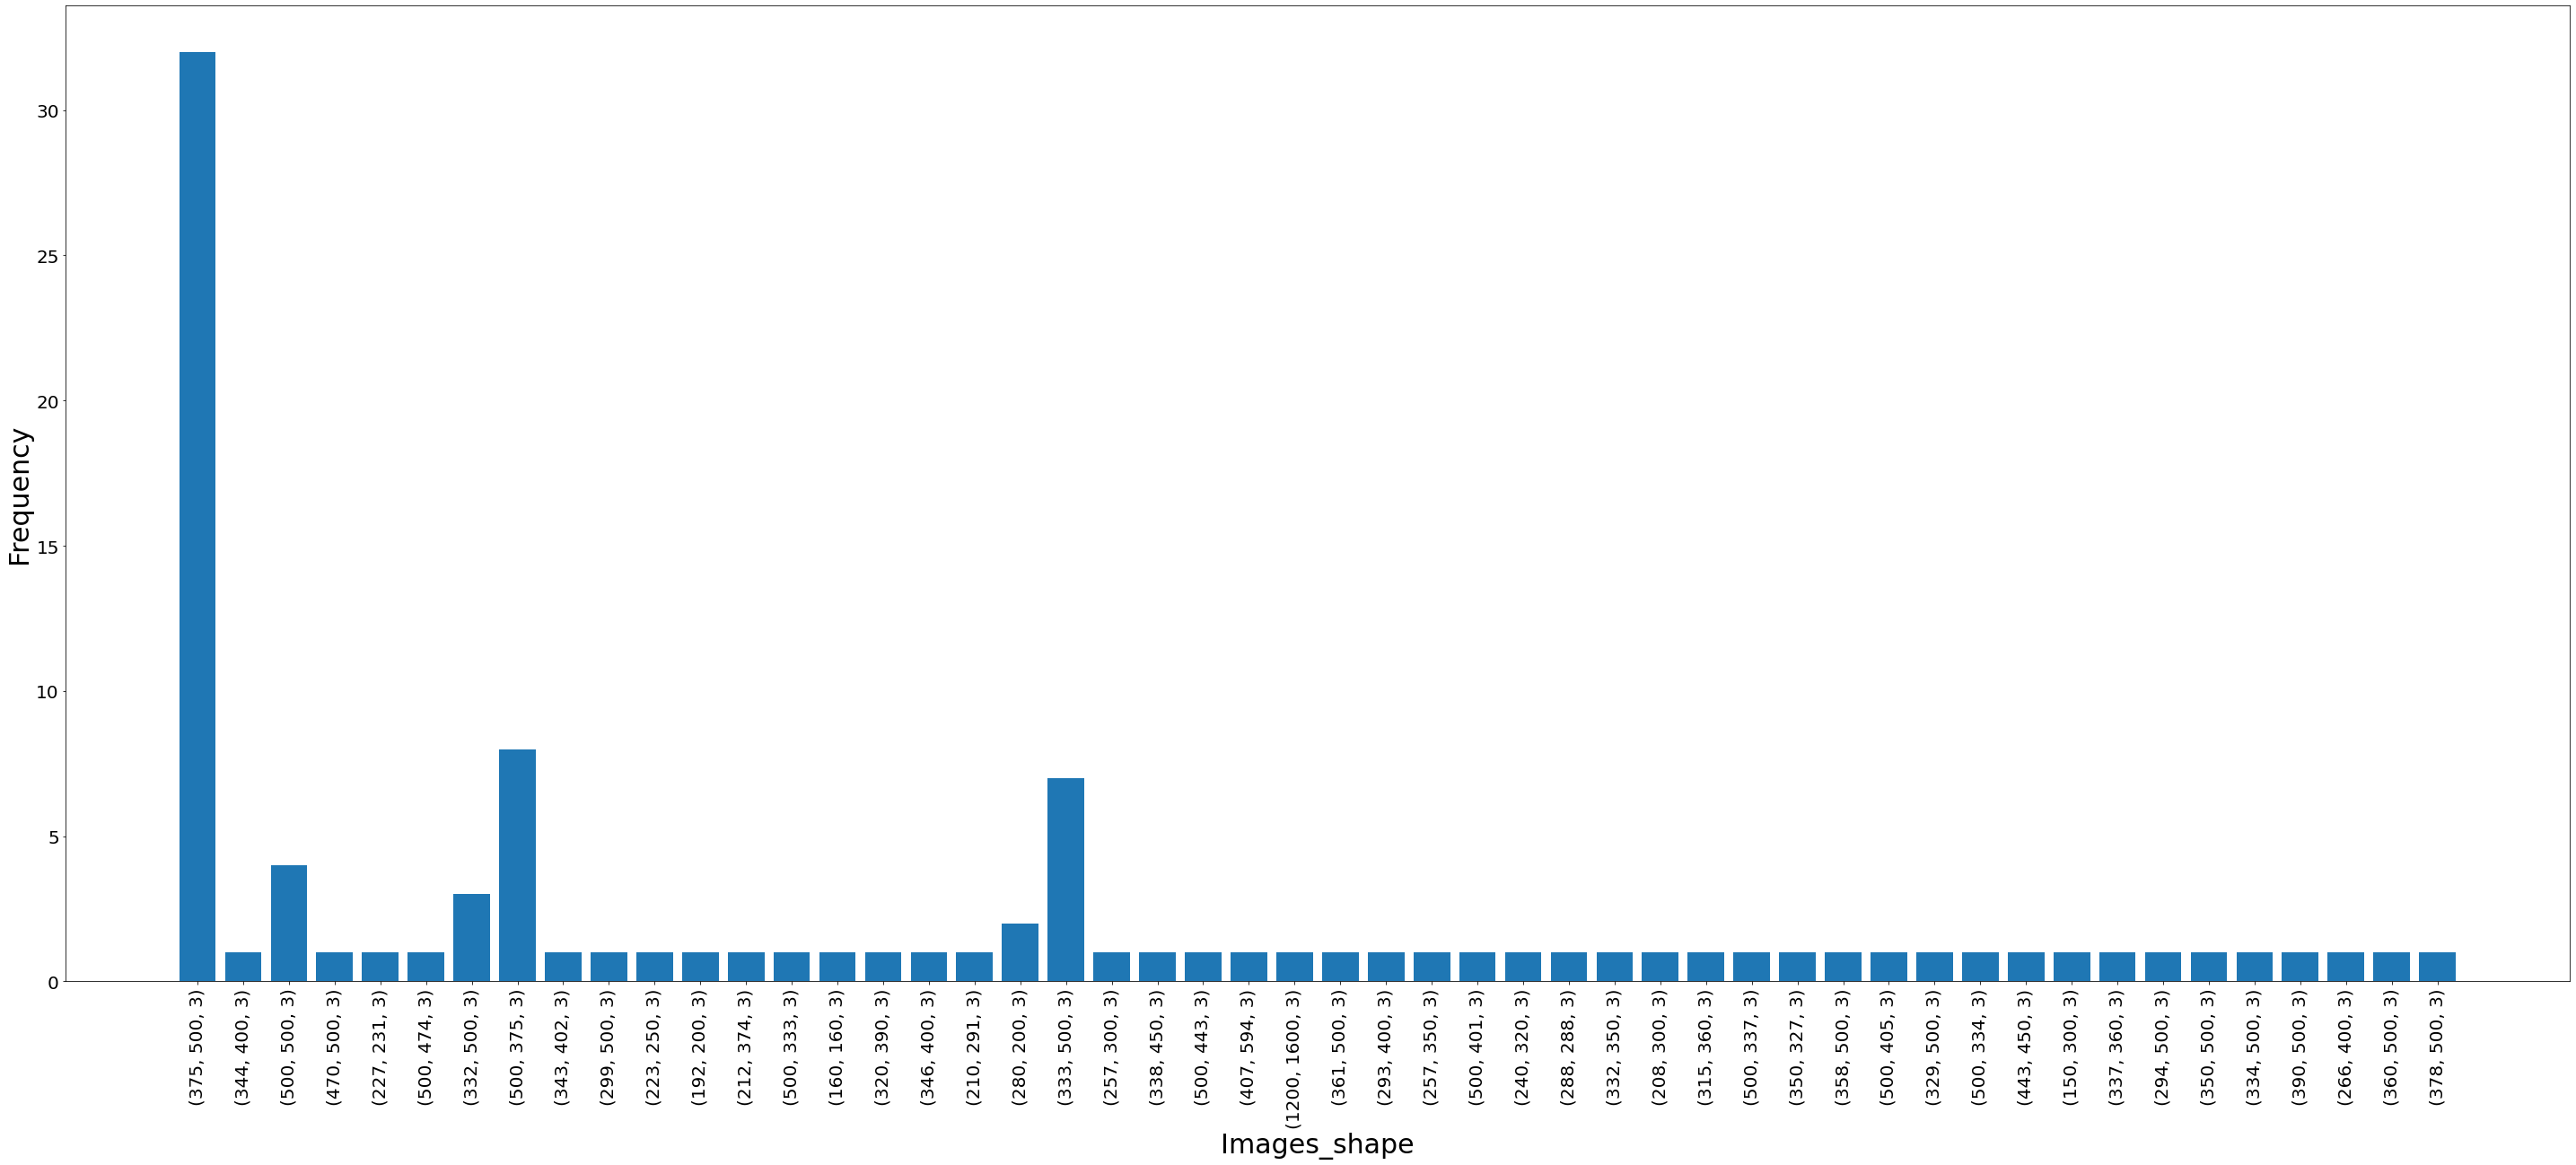

In [5]:
images_names = list(label['id_jpg'].head(100))
# find out details about the images samples
images_dim = {}
for img in images_names:
  full_path = train_dir + img
  n = cv2.imread(full_path)
  shape_string = str(n.shape)
  if not shape_string in images_dim:
    images_dim[shape_string] = 1
  else:
    images_dim[shape_string] = images_dim[shape_string]+1

plt.figure(figsize=(50,20))
plt.bar(list(images_dim.keys()),list(images_dim.values()))
plt.xlabel("Images_shape", size=30)
plt.ylabel("Frequency", size=30)
plt.xticks(rotation=90,fontsize=20)
plt.yticks(fontsize=20)
plt.savefig(dog_dir+'dogs_img_dim.jpg')
# plt.show()


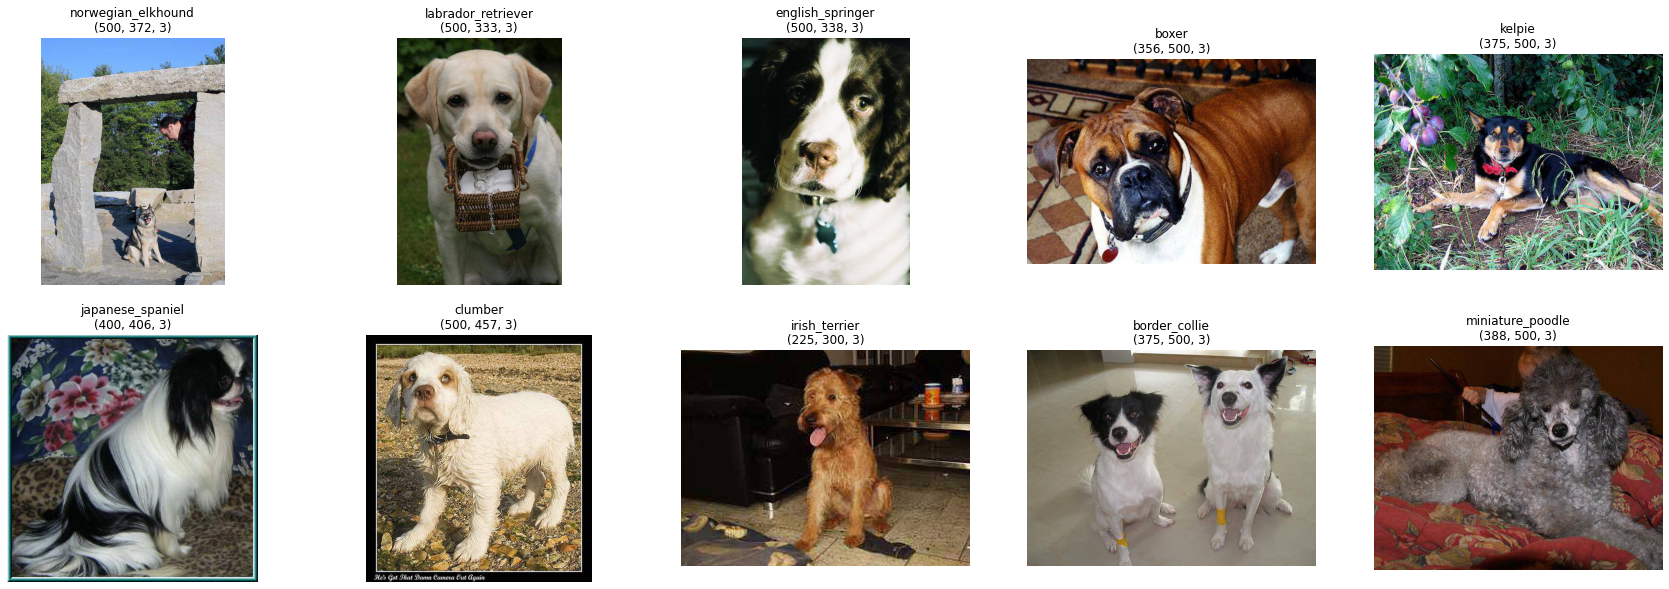

In [6]:

fig,axes = plt.subplots(2,5,figsize = (30,10))

for ax in axes.reshape(-1,):
    rnd_idx = np.random.randint(label.index[0],label.index[-1])
    file_path = label.loc[rnd_idx,'path']
    arr = plt.imread(file_path)
    ax.imshow(arr)
    ax.set_title(label.loc[rnd_idx,'breed']+'\n'+str(arr.shape))
    ax.axis('off')

plt.savefig(dog_dir+'dog_images.jpg')
# plt.show()

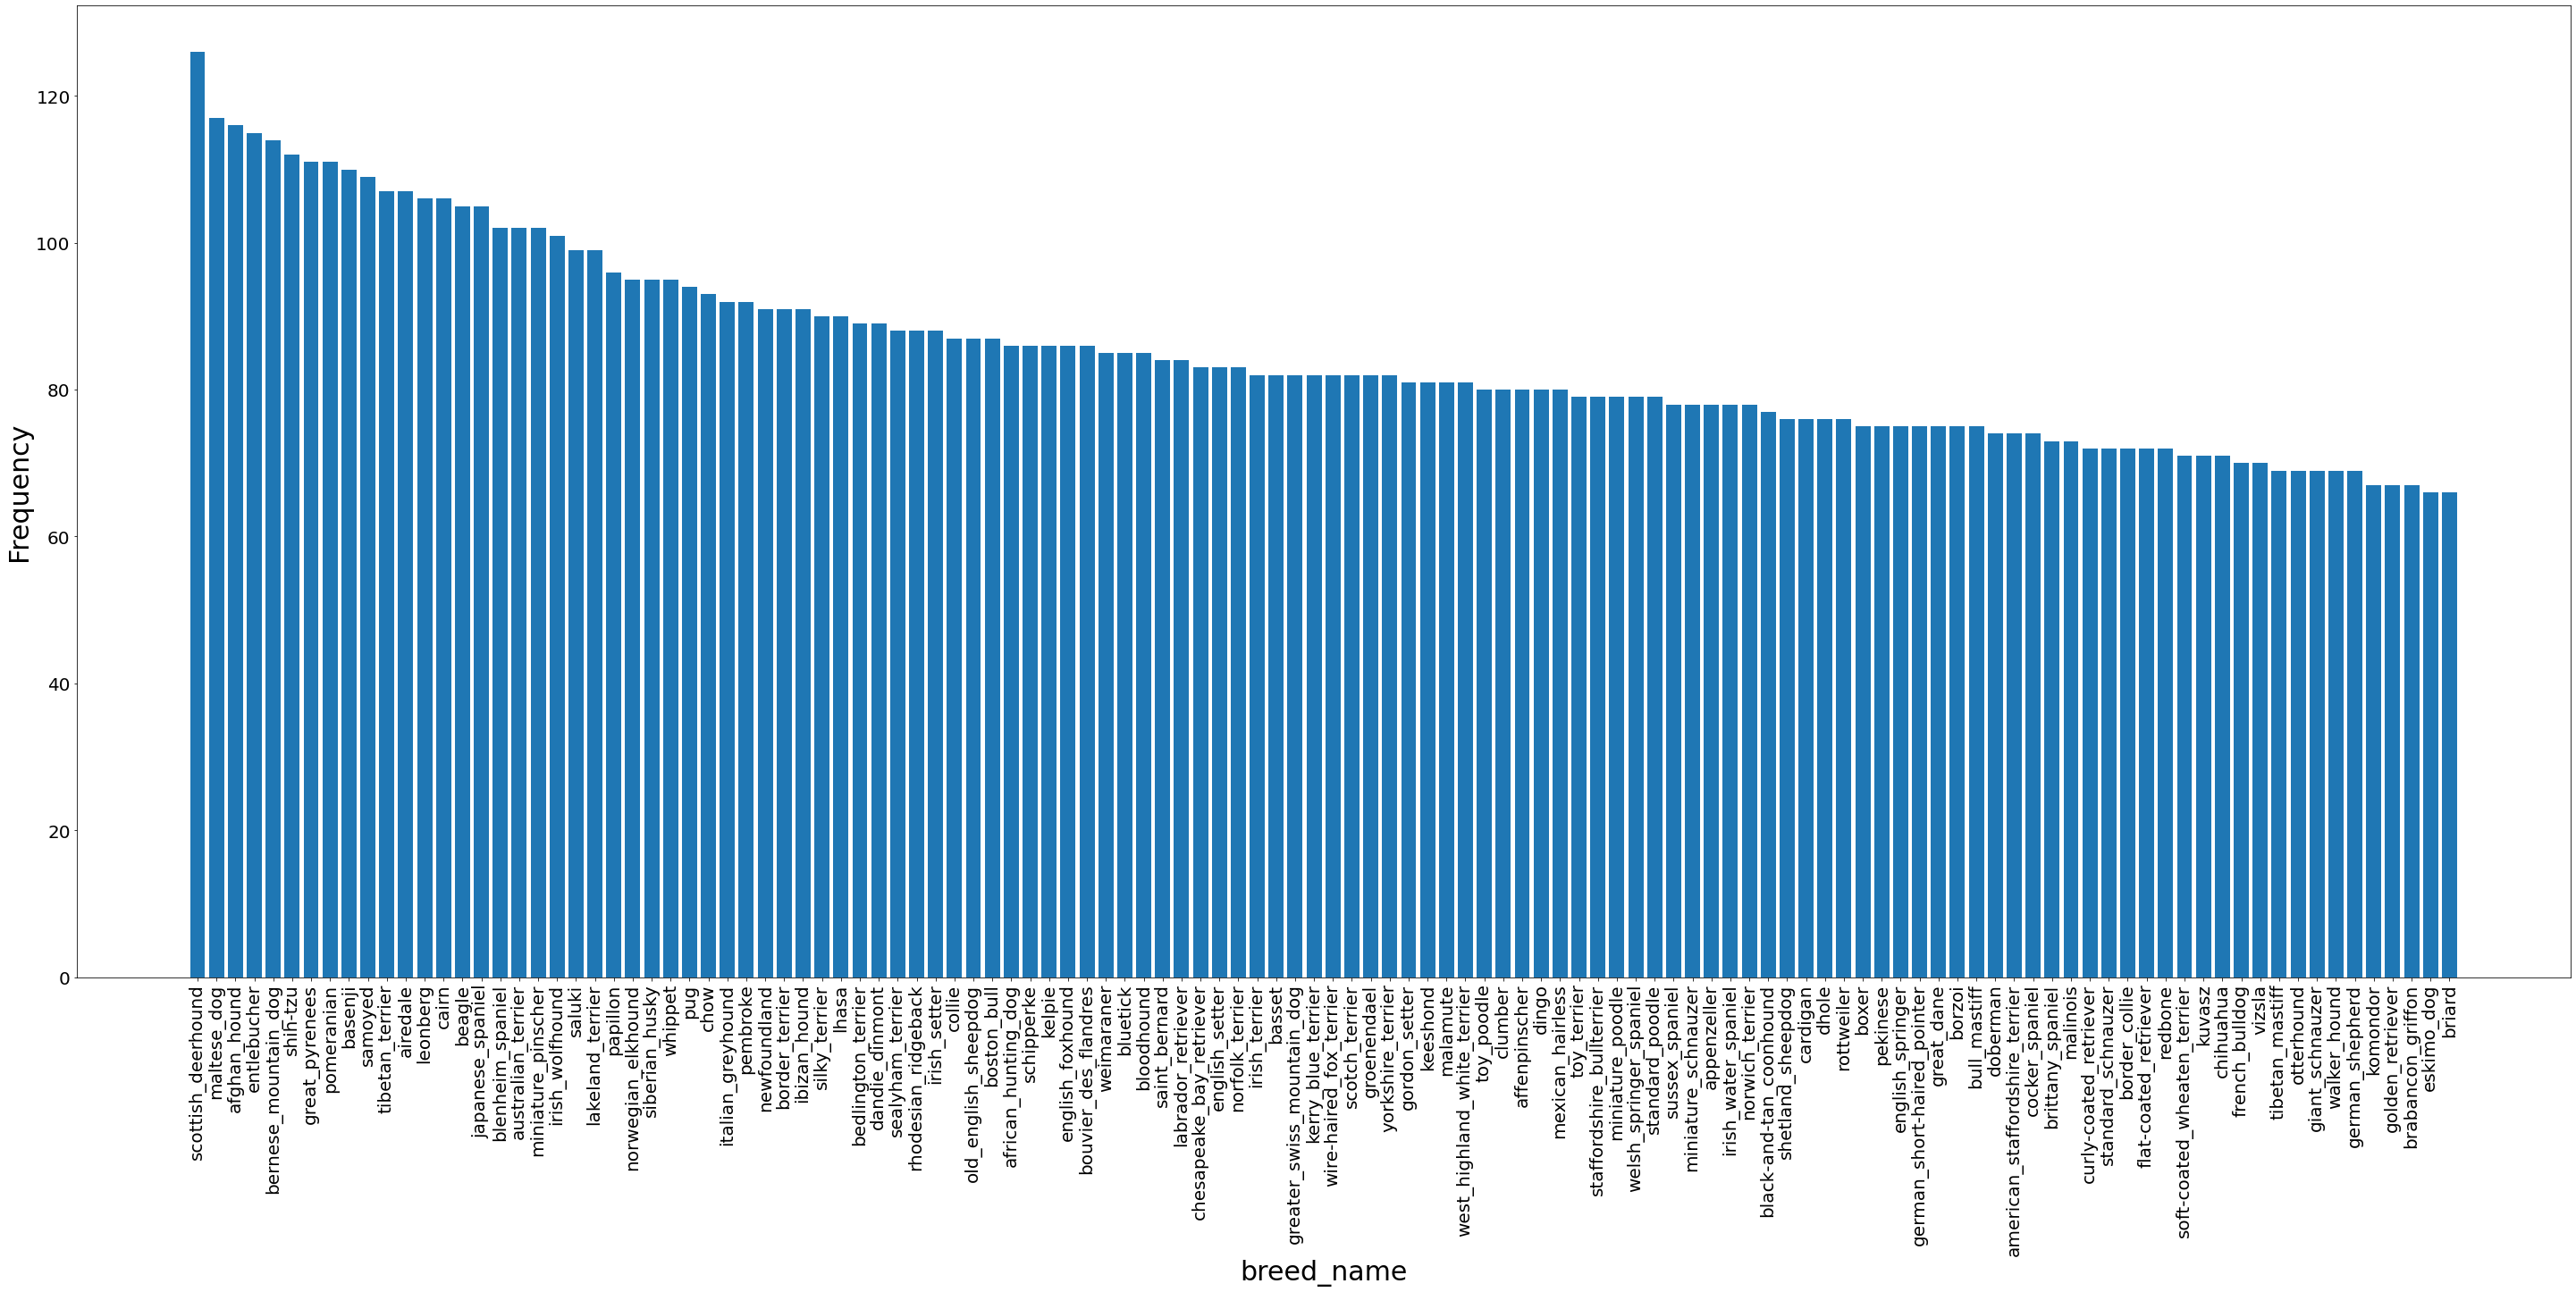

In [7]:
label_df = pd.DataFrame(label['breed'].value_counts()).reset_index() # count how many labels of each breed
label_df.columns = ['breed_name', 'count'] # change cols names
label_df.sort_values(by="count", ascending=False)

plt.figure(figsize=(50,20))
plt.bar(list(label_df['breed_name']),list(label_df['count']))
plt.xlabel("breed_name", size=30)
plt.ylabel("Frequency", size=30)
plt.xticks(rotation=90,fontsize=20)
plt.yticks(fontsize=20)
plt.savefig(dog_dir+'count_breeds.jpg')
# plt.show()

a. 

*   the size of the data is: 10222 samples.

b. 

  *     the data is images of difference kinds of dogs.

  *     all images have 3 channels

  *   as we can see from the plot, all images are not of the same dimensions

  *   by first 100 images the popular dimension is (375,500)
    
  *   that means we need to pre-process our data and convert all images to same dimensions

  *   we should use augmentation to enlarge our data and decrease the overfitting

  *   because we are dealing with dogs picture, we can make augmentation like: minimal rotation, zoom in/out, horizontal flip, width/height shift range

  *   we cant use vertical flip for example because it doen't suits to the problem we are trying to solve

  *   the data is not balanced, there are over 120 images for the common breed and 60-70 images for the rare ones







In [8]:

def confusion_matrix_predict(model, validation_generator):
    preds = model.predict(validation_generator)
    predicts = np.argmax(preds, axis=1)  # return the predicted category in each sample in test set
    print(confusion_matrix(validation_generator.labels, predicts))
    print('model accuracy on test set is: {}%'.format(accuracy_score(validation_generator.labels, predicts) * 100))
    sns.heatmap(confusion_matrix(validation_generator.labels, predicts), cmap='Greens', annot=False, fmt='d')
    plt.xlabel('Prediction')
    plt.ylabel('True label')
    plt.title('Classification results on test set')
    plt.show()

def plot_history(history):

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

Question 2:


In [9]:
train_csv_path = dog_dir + r'data/new_labels.csv'
test_csv_path =  dog_dir + r'data/test_submission.csv'
test_csv_submission = dog_dir + r'data/test_predictions.csv'
train_image_directory = dog_dir + r'train/'
test_image_directory = dog_dir + r'data/test'
models_directory = dog_dir + r'data/models'
model_checkpoint_filepath = dog_dir + r'data/model/bestModel'
model_predictions_directory= dog_dir + r'/data/model'
batch_size = 32
kfold = 5
epochs = 60
target_class = "breed"
full_run = False
load_model = False

In [10]:
def get_base_model(n_classes):
    inp = Input(shape=(64, 64, 3))

    x = Conv2D(32, 3, activation='relu')(inp)
    x = Dropout(0.1)(x)
    x = MaxPool2D()(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, 3, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(128, 3, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(256, 3, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    x = Conv2D(512, 3, activation='relu')(x)
    x = Dropout(0.35)(x)
    x = MaxPool2D()(x)
    x = BatchNormalization()(x)

    x = Flatten()(x)
    x = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=inp, outputs=x)
    model.summary()
    return model

    
def  classWeights():
    class_weight ={}
    for index in range(0,121,1):
        class_weight[index]= 1/120
    class_weight[95]= 5/120
    class_weight[8] = 5 / 120
    class_weight[45] = 5 / 120
    class_weight[56] = 5 / 120
    class_weight[26] = 5 / 120
    class_weight[64] = 5 / 120
    class_weight[99] = 5 / 120
    class_weight[103] = 5 / 120
    return class_weight


def remove_jpg(list):
    new_list = []
    for im in list:
        new_im = im.replace(".jpg", "")
        new_list.append(new_im)
    return new_list


In [11]:

# load data train, test
train_df = pd.read_csv(train_csv_path)
print("Training samples: " + str(train_df.shape[0]))

if full_run:
    test_df = pd.read_csv(test_csv_path)
    print("Test samples: " + str(test_df.shape[0]))
    # create target classs distribution
    size = (16.8, 8.27)
    fig, ax = plt.subplots(figsize=size)
    splot = sns.countplot(ax=ax, x=target_class, data=train_df)
    plt.title("Distribution of dog breeds")
    plt.xlabel("Dog breed")
    plt.ylabel("Frequency")
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.0f'),
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center',
                        size=10,
                        xytext=(0, -8),
                        textcoords='offset points')
    _ = plt.xticks(rotation=90)
    plt.show()
    # show samples of the problem

    examples =train_df['id'].head(16)
    count_pic = 0
    index = 0
    for e in examples:
        sub = fig.add_subplot(16, 16, count_pic + 1)
        full_path =train_image_directory + "\\" + e
        emage = mpimg.imread(full_path)
        sub.imshow(emage)
        sub.set_title(train_df.loc[index, 'breed'])
        # sub.text(0,0, color='red', weight='bold',fontsize=15)
        count_pic = count_pic + 1
        index = index + 1
        if count_pic == 16:
            break
    plt.show()

Training samples: 10222


In [12]:

train_generator = ImageDataGenerator(rescale=1./255,
                             horizontal_flip = True,
                             fill_mode='nearest',
                             rotation_range=10,
                             width_shift_range=0.15,
                             channel_shift_range=0.2,
                             shear_range=0.01,
                             height_shift_range=0.15)

test_generator = ImageDataGenerator(rescale=1./255,
                                    fill_mode='nearest')

target_class=train_df['breed']
image_ids = train_df['id']

num_classes = train_df['breed'].unique().size
skf = StratifiedKFold(n_splits=kfold, shuffle=True ,random_state=7)
y_columns = train_df['breed'].unique()

losses_cv = []
accuracy_cv = []


Found 8177 validated image filenames.
Found 2045 validated image filenames.
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 31, 31, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
____________________________________________

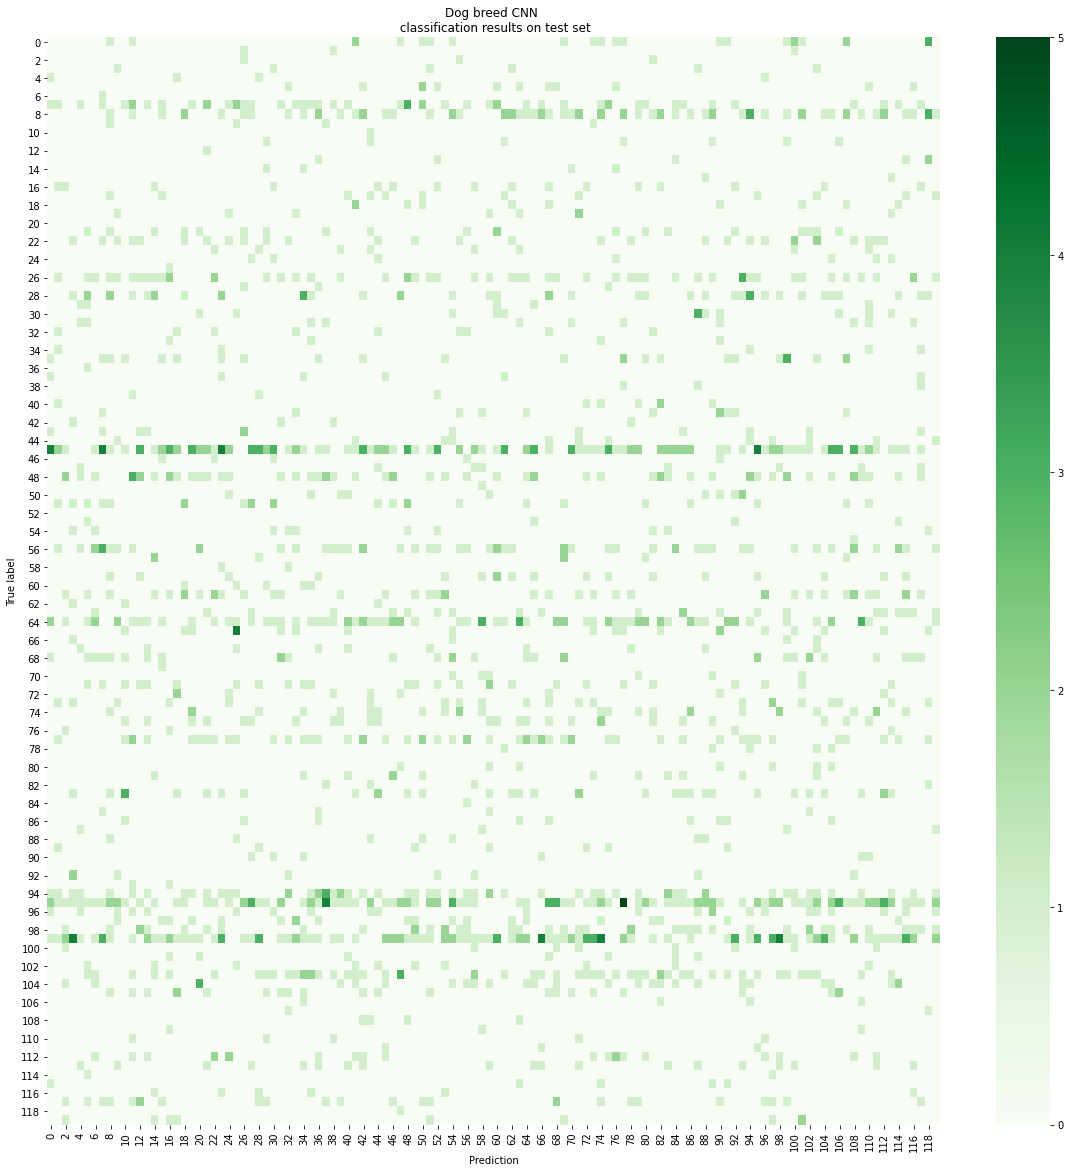

64/64 [==============================] - 10s 156ms/step - loss: 4.1155 - accuracy: 0.1394


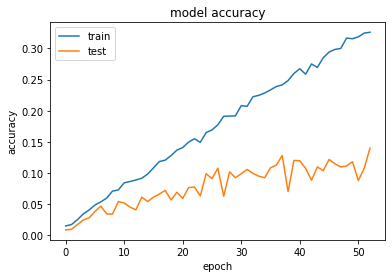

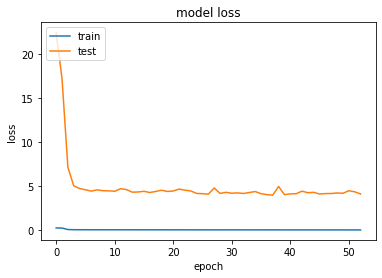

Found 8177 validated image filenames.
Found 2045 validated image filenames.
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
dropout_5 (Dropout)          (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 31, 31, 32)        128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 29, 29, 64)        18496     
____________________________________________

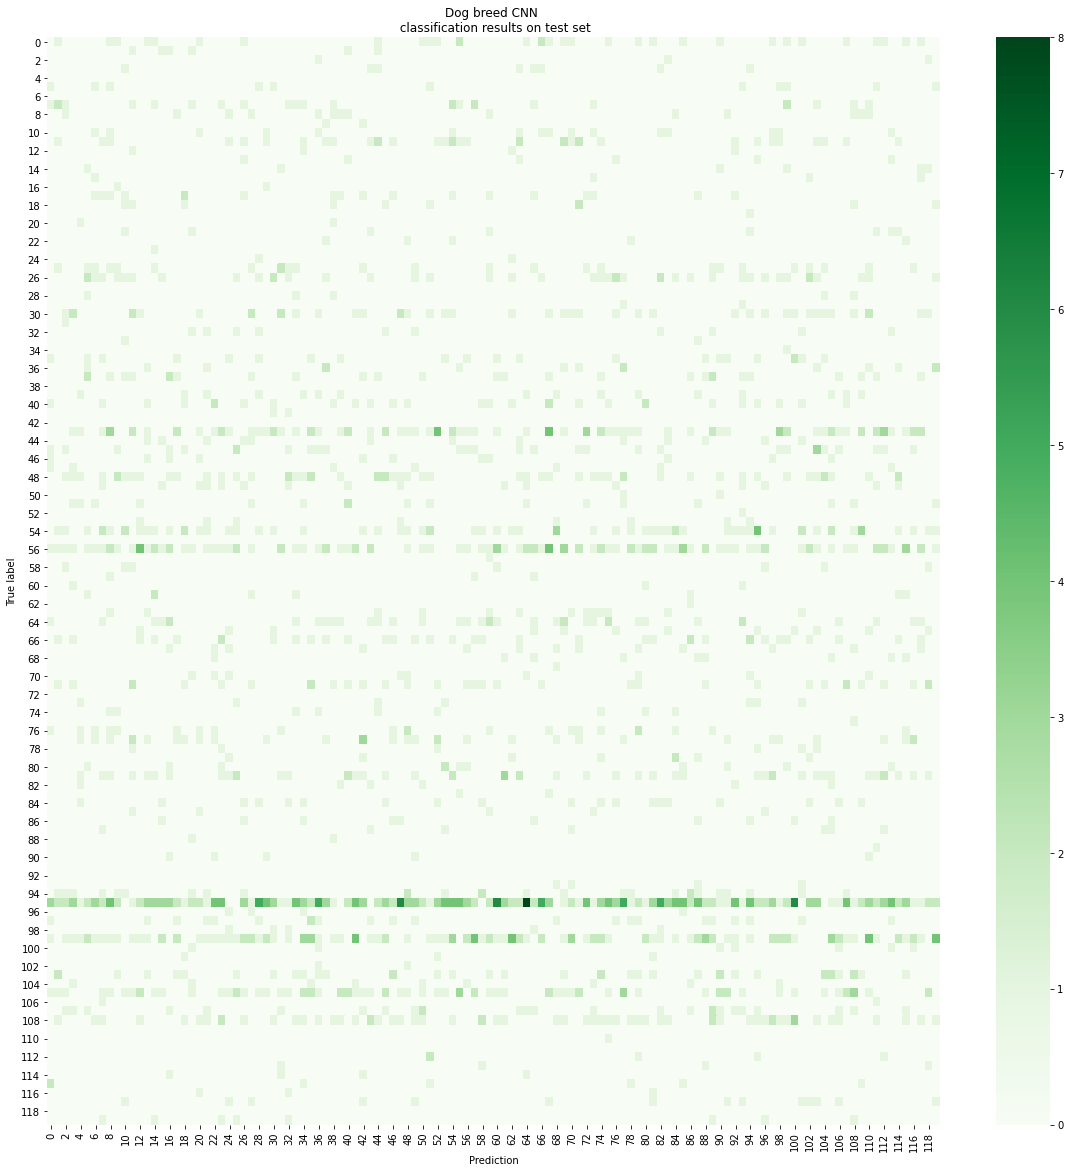

64/64 [==============================] - 10s 161ms/step - loss: 4.4204 - accuracy: 0.1213


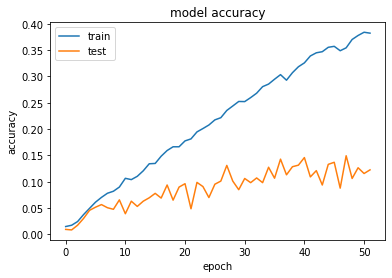

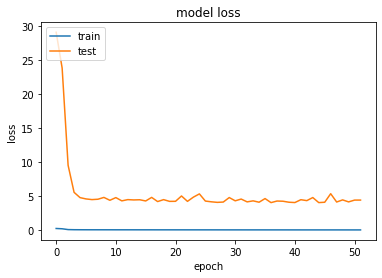

Found 8178 validated image filenames.
Found 2044 validated image filenames.
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
dropout_10 (Dropout)         (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 31, 31, 32)        128       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 29, 29, 64)        18496     
____________________________________________

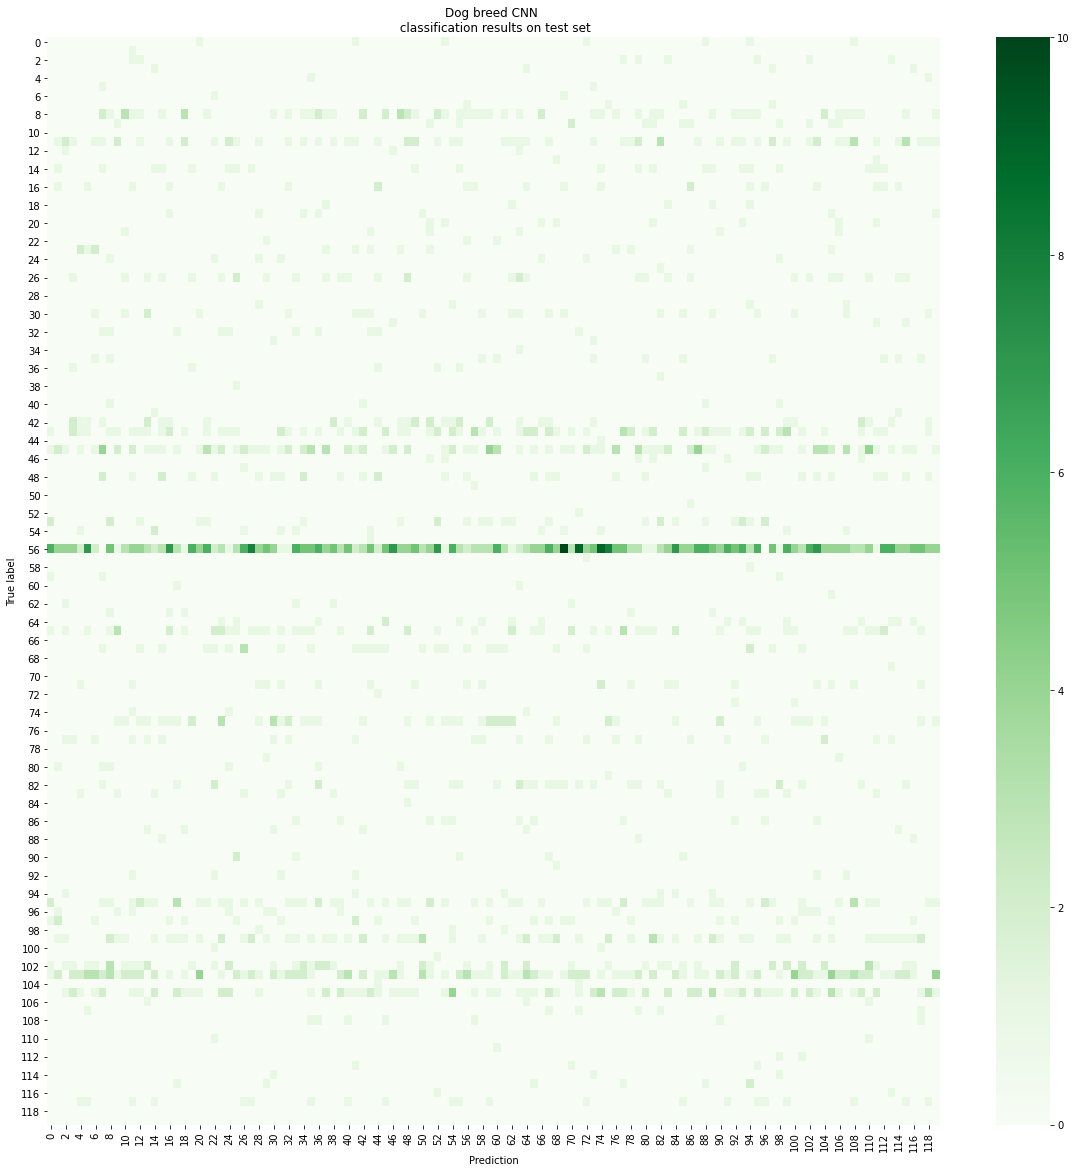

64/64 [==============================] - 10s 162ms/step - loss: 4.1706 - accuracy: 0.1057


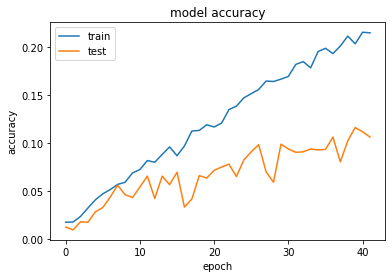

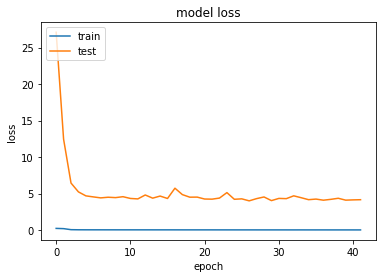

Found 8178 validated image filenames.
Found 2044 validated image filenames.
Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
dropout_15 (Dropout)         (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 31, 31, 32)        128       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 29, 29, 64)        18496     
____________________________________________

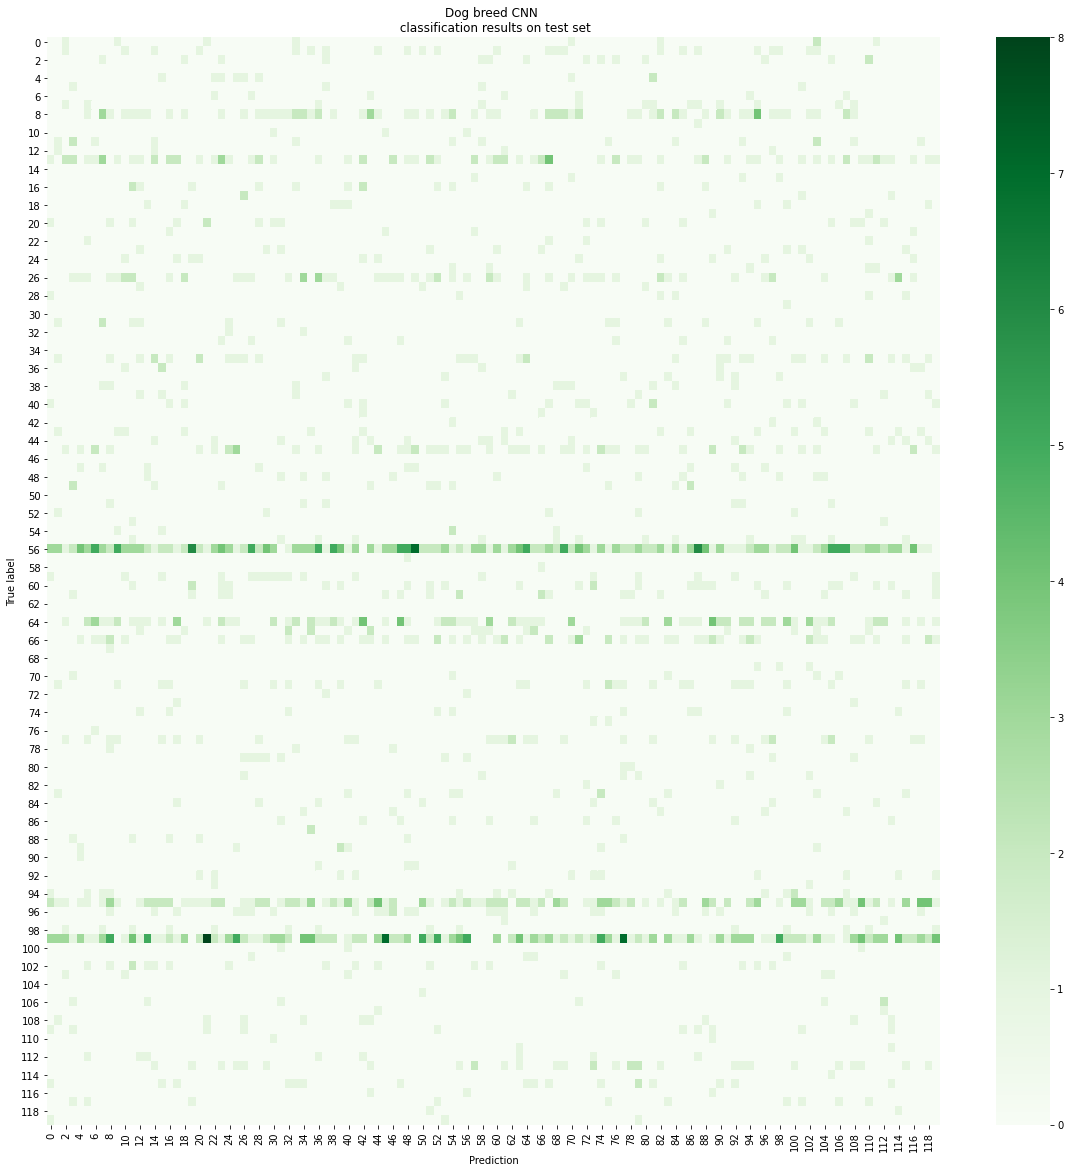

64/64 [==============================] - 10s 160ms/step - loss: 4.3683 - accuracy: 0.1140


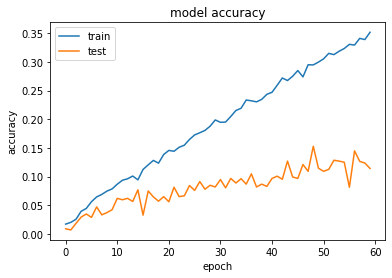

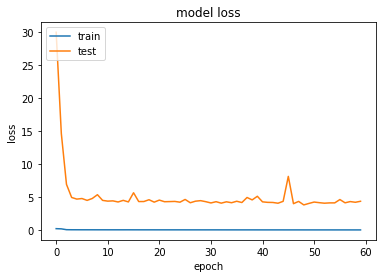

Found 8178 validated image filenames.
Found 2044 validated image filenames.
Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
dropout_20 (Dropout)         (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 31, 31, 32)        128       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 29, 29, 64)        18496     
____________________________________________

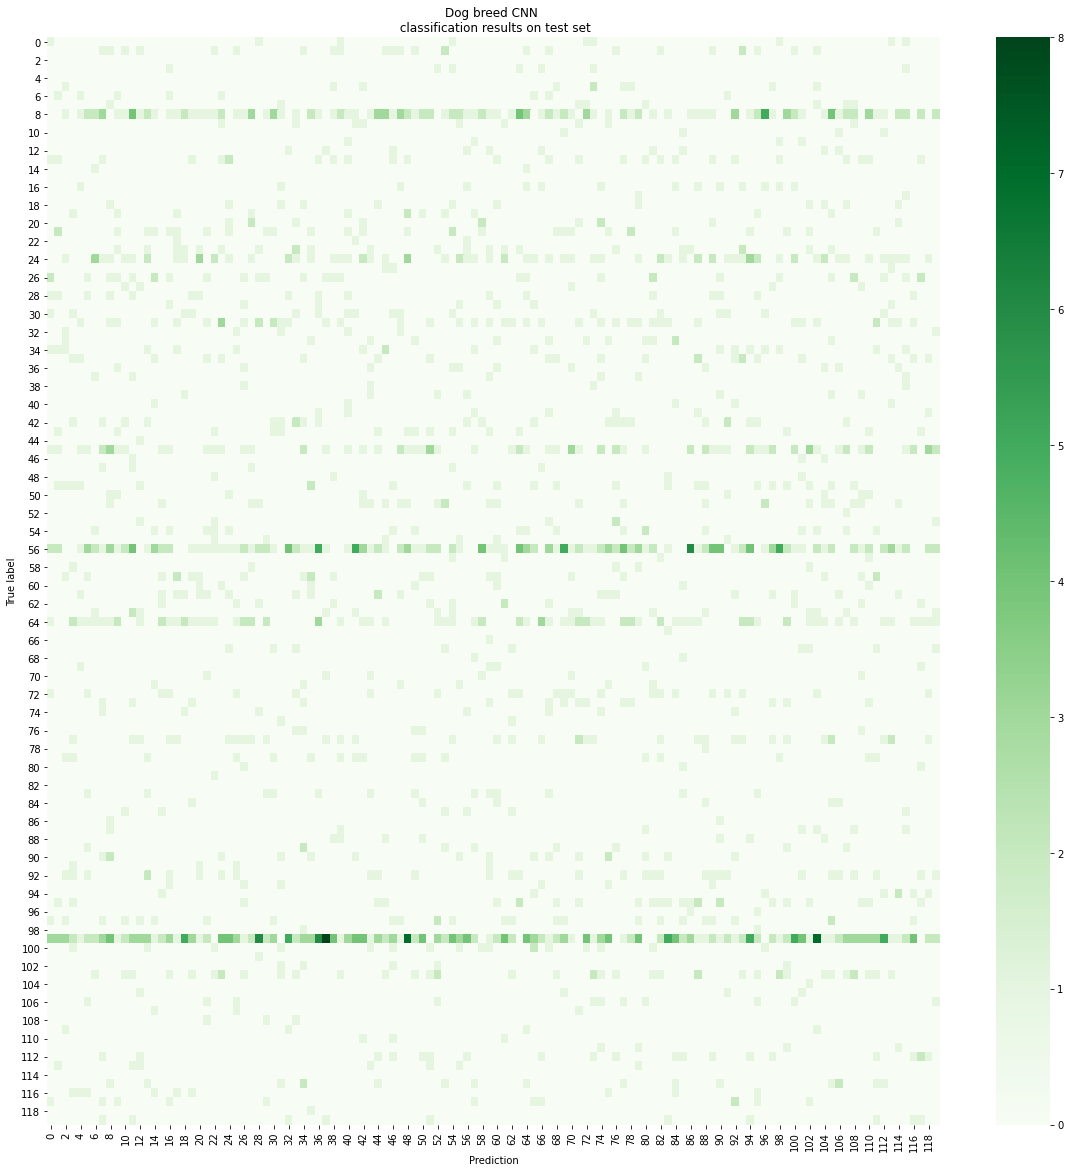

64/64 [==============================] - 10s 159ms/step - loss: 4.4737 - accuracy: 0.1194


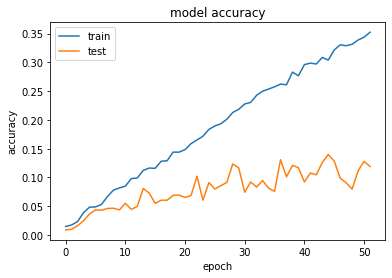

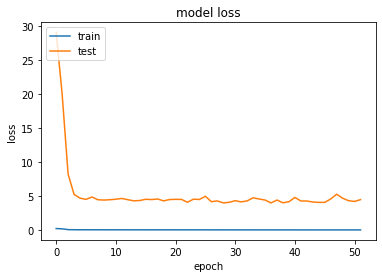

In [13]:
# one hot
label_onehot = pd.get_dummies(train_df,columns=['breed'],prefix=None)
label_onehot.columns = label_onehot.columns.str.replace(r'breed_', '') # remove breed_ prefix
label_onehot=label_onehot.rename(columns={'id_ext':'id'})

kf=1
for train, test in skf.split(image_ids,target_class):
    training_df = label_onehot.iloc[train]
    testing_df = label_onehot.iloc[test]
    train_data_generator = train_generator.flow_from_dataframe(training_df,
                                                                directory=train_image_directory,
                                                                x_col = "id",
                                                                y_col = y_columns,
                                                                target_size=(64, 64),
                                                                batch_size=batch_size,
                                                                class_mode="raw",
                                                                shuffle=True,
                                                                interpolation="bicubic",
                                                                )

    valid_data_generator = test_generator.flow_from_dataframe(testing_df,
                                                                directory=train_image_directory,
                                                                x_col="id",
                                                                y_col= y_columns,
                                                                batch_size=batch_size,
                                                                target_size=(64, 64),
                                                                class_mode="raw",
                                                                shuffle=True,
                                                                interpolation="bicubic",
                                                                )

    model = get_base_model(num_classes)
    if load_model :
        model.load_weights(model_checkpoint_filepath + str(kf) + ".hdf5")
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    model_checkpoint_callback = ModelCheckpoint(filepath=model_checkpoint_filepath+str(kf)+".hdf5",
                                                                   verbose=1,
                                                                   monitor='val_accuracy',
                                                                   mode='max',
                                                                   save_best_only=True)

    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,patience=10, min_lr=0.001)
    early_st =EarlyStopping(patience=15)
    callBacks =[model_checkpoint_callback,reduce_lr,early_st]
    class_weight = classWeights()
    history = model.fit(train_data_generator,
                        epochs=epochs,
                        callbacks=callBacks,
                        class_weight=class_weight,
                        steps_per_epoch=train_data_generator.samples // batch_size,
                        validation_steps=valid_data_generator.samples // batch_size,
                        validation_data=valid_data_generator)

    # predict validation data
    predictions = model.predict(valid_data_generator)

    # save model predictions for analysis
    list_test_images = valid_data_generator.filenames
    predictions_df = pd.DataFrame(predictions)
    predictions_df.columns = y_columns
    predictions_df.insert(0, 'id', list_test_images)
    predictions_df.to_csv(model_predictions_directory + "\predictions" + str(kf) + ".csv")

    # create and plot confusion matrix
    actual_answers = valid_data_generator.labels
    predictions = np.argmax(predictions, axis=1)
    actual_answers = np.argmax(actual_answers, axis=1)
    size = (20, 20)
    fig, ax = plt.subplots(figsize=size)
    sns.heatmap(confusion_matrix(predictions,actual_answers), cmap='Greens',annot=False, fmt='d',ax=ax)
    plt.xlabel('Prediction')
    plt.ylabel('True label')
    plt.title('Dog breed CNN \n classification results on test set')
    plt.show()

    # save and plot model metrics
    results = model.evaluate(valid_data_generator)
    accuracy = results[1]
    loss = results [0]
    accuracy_cv.append(accuracy)
    losses_cv.append(loss)

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    kf+=1


In [14]:

# print kfold results
print("Total loss: " + str(losses_cv))
average_loss = np.mean(losses_cv)
print("Average loss: " + str(average_loss))
average_accuracy = np.mean(accuracy_cv)
print("Total accuracy: " + str(accuracy_cv))
print("Average accuracy: " + str(average_accuracy ))


Total loss: [4.115529537200928, 4.420351028442383, 4.170600891113281, 4.3683366775512695, 4.473679065704346]
Average loss: 4.309699440002442
Total accuracy: [0.1393643021583557, 0.12127139419317245, 0.10567514598369598, 0.11399216949939728, 0.11937377601861954]
Average accuracy: 0.11993535757064819


Question 3:

In [15]:
image_size = 224
input_shape = (image_size, image_size, 3)
batch_size = 32

In [16]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=18,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split = 0.20
)


train_generator = train_datagen.flow_from_dataframe(
    label,
    r'gdrive/My Drive/dog-breed-identification/train/',
    x_col='id_jpg',
    y_col='breed',
    class_mode='categorical',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    color_mode = 'rgb',
    seed=42,
    shuffle=False,
    subset = 'training'
    
)


validation_generator = train_datagen.flow_from_dataframe(
    label,
    r'gdrive/My Drive/dog-breed-identification/train/',
    x_col='id_jpg',
    y_col='breed',
    class_mode='categorical',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    color_mode = 'rgb',
    seed=42,
    shuffle=False,
    subset = 'validation',
)

classes = train_generator.class_indices


Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.


In [17]:
pre_trained_model = inception_v3.InceptionV3(include_top = False, weights = 'imagenet', input_shape = input_shape)

pre_trained_model.trainable = False
for layer in pre_trained_model.layers:
    layer.trainable = False
    
pre_trained_model.summary()

model = Sequential([
    pre_trained_model,
    Flatten(),
    Dense(512,activation ='relu'),
    Dropout(0.3),
    Dense(256,activation ='relu'),
    Dropout(0.3),
    Dense(120,activation = 'softmax')
])

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 111, 111, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, 111, 111, 32) 96          conv2d_25[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization_25[0][0]     
______________________

train model:

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/70
255/255 [==============================] - ETA: 0s - loss: 4.7313 - accuracy: 0.1482
Epoch 00001: val_accuracy improved from -inf to 0.36012, saving model to gdrive/My Drive/model_saved1.hdf5
255/255 [==============================] - 145s 568ms/step - loss: 4.7313 - accuracy: 0.1482 - val_loss: 2.8718 - val_accuracy: 0.3601
Epoch 2/70
255/255 [==============================] - ETA: 0s - loss: 3.3695 - accuracy: 0.2774
Epoch 00002: val_accuracy improved from 0.36012 to 0.42460, saving model to gdrive/My Drive/model_saved1.hdf5
255/255 [==============================] - 142s 558ms/step - loss: 3.3695 - accuracy: 0.2774 - val_loss: 2.4532 - val_accuracy: 0.4246
Epoch 3/70
255/255 [==============================] - ETA: 0s - loss: 3.0484 - accuracy: 0.3152
Epoch 00003: val_accuracy improved from 0.42460 to 0.48264, saving model to gdrive/My Drive/model_saved1.hdf5
255/255 [==============================

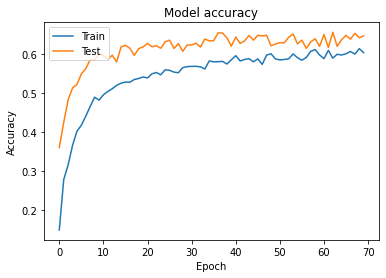

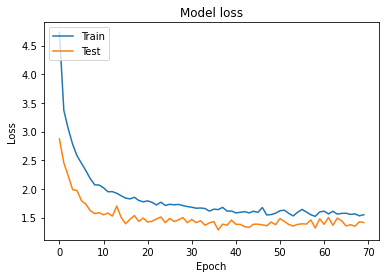

[[11  0  0 ...  0  0  0]
 [ 0 17  0 ...  0  0  0]
 [ 0  0 10 ...  0  0  0]
 ...
 [ 0  0  0 ...  4  0  0]
 [ 0  0  0 ...  0  3  0]
 [ 0  0  0 ...  0  0  7]]
model accuracy on test set is: 63.45401174168297%


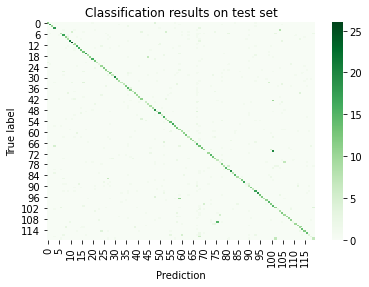

In [18]:
model_checkpoint_filepath = r'gdrive/My Drive/model_saved1.hdf5'
model_checkpoint_callback = ModelCheckpoint(filepath=model_checkpoint_filepath, verbose=1, monitor='val_accuracy',
                                                mode='max', save_best_only=True)

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(), metrics = ['accuracy'])

history = model.fit_generator(generator = train_generator,
                           epochs = 70,
                           steps_per_epoch  = train_generator.n//train_generator.batch_size,
                           validation_data  = validation_generator,
                           validation_steps = validation_generator.n//validation_generator.batch_size,
                           callbacks=[model_checkpoint_callback]
                           )


loss, accuracy = model.evaluate_generator(validation_generator, validation_generator.batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

plot_history(history) 
confusion_matrix_predict(model,validation_generator)

checking our predictions:

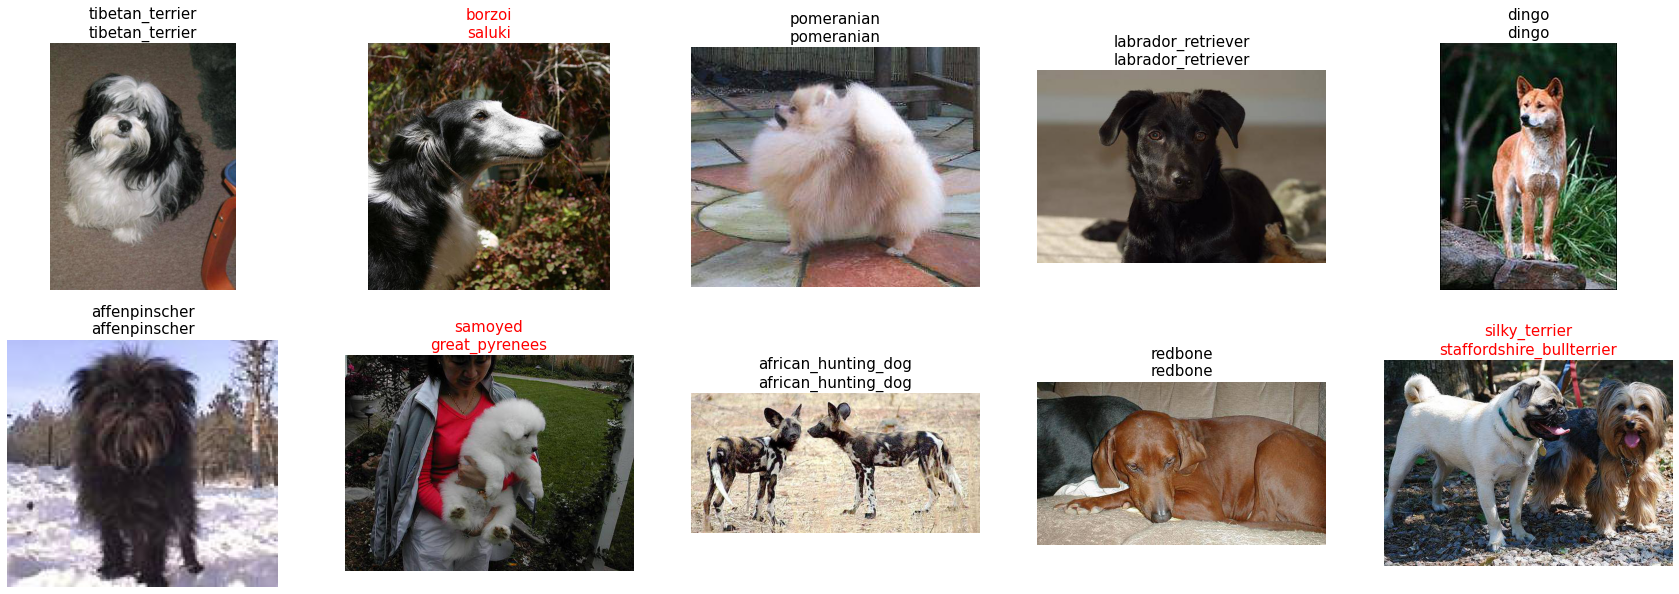

In [19]:
val_pred = np.argmax(model.predict(validation_generator),axis=-1)
classes = {x:y for y,x in classes.items()}

fig,axes = plt.subplots(2,5,figsize = (30,10))

for ax in axes.reshape(-1,):
    rnd_idx = np.random.randint(0,len(validation_generator.filepaths))
    arr = plt.imread(validation_generator.filepaths[rnd_idx])
    ax.imshow(arr)
    breed_true = classes[validation_generator.classes[rnd_idx]]
    breed_pred = classes[val_pred[rnd_idx]]
    
    if breed_true != classes[val_pred[rnd_idx]]:
        ax.set_title(breed_true+'\n'+ breed_pred, color = 'red',fontsize = 15)
    else:
        ax.set_title(breed_true+'\n'+ breed_pred, color = 'black',fontsize = 15)

    ax.axis('off')

loading model:

In [20]:
# model.load_weights(model_checkpoint_filepath)

# model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# model.summary()

Logistic Regression running time is: 133.9178740978241
[[12  0  0 ...  2  0  0]
 [ 0 16  0 ...  1  0  0]
 [ 0  0  9 ...  0  0  0]
 ...
 [ 0  0  0 ... 15  0  0]
 [ 0  0  0 ...  0  6  0]
 [ 0  0  0 ...  2  0 13]]
model accuracy on validation set is: 64.92172211350294%


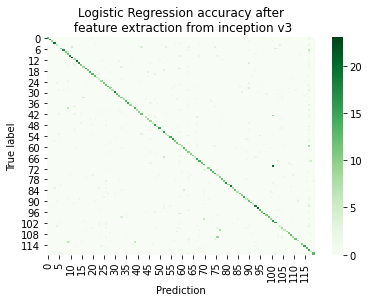

In [21]:
time_start_logreg = time.time()

extract_features = Model(model.input, model.layers[-1].output)
features_of_train = extract_features.predict(train_generator)
features_of_test = extract_features.predict(validation_generator)

lrc = LogisticRegression(multi_class='multinomial', solver='lbfgs', n_jobs=8)
values_arr = list(train_generator.labels)
lrc.fit(features_of_train, values_arr)
preds = lrc.predict(features_of_test)

time_end_logreg = time.time()
print('Logistic Regression running time is: ' + str(time_end_logreg - time_start_logreg))

print(confusion_matrix(validation_generator.labels , preds))
print('model accuracy on validation set is: {}%'.format(accuracy_score(validation_generator.labels ,preds)*100))
# print('model log loss on validation set is: {}%'.format(log_loss(validation_generator.labels ,preds)*100))

sns.heatmap(confusion_matrix(validation_generator.labels,preds),cmap='Greens',annot=False, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True label')
plt.title('Logistic Regression accuracy after\n feature extraction from inception v3')
plt.show()